In [20]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
from tensorflow.keras import backend as K
import numpy as np

# Load MNIST dataset


In [21]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [22]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 10

# VAE model = encoder + decoder

In [23]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


In [24]:
# reparameterization
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [25]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

## Encoder

In [26]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense_15 (Dense)            (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense_15[0][0]']            
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense_15[0][0]']            
                                                                                            

## Decoder

In [27]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_16 (Dense)            (None, 512)               1536      
                                                                 
 dense_17 (Dense)            (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# VAE model


In [28]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

## VAE loss = mse_loss + kl_loss


In [29]:
reconstruction_loss = mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [30]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  403972    ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  403728    ['encoder[0][2]']             
                                                                                            

In [31]:
# Train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Epoch 1/10
469/469 [==============================] - 5s 9ms/step - loss: 51.5216 - val_loss: 43.6735
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 43.1773 - val_loss: 42.3880
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 42.2020 - val_loss: 41.6675
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 41.6061 - val_loss: 41.1768
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 41.1736 - val_loss: 40.8216
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 40.8312 - val_loss: 40.4996
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 40.5387 - val_loss: 40.3282
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 40.2754 - val_loss: 40.1219
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 40.0493 - val_loss: 39.8312
Epoch 10/10
469/469 [==============================] - 4s 9ms/step - loss: 39.8073

1/1 [==============================] - 0s 15ms/step


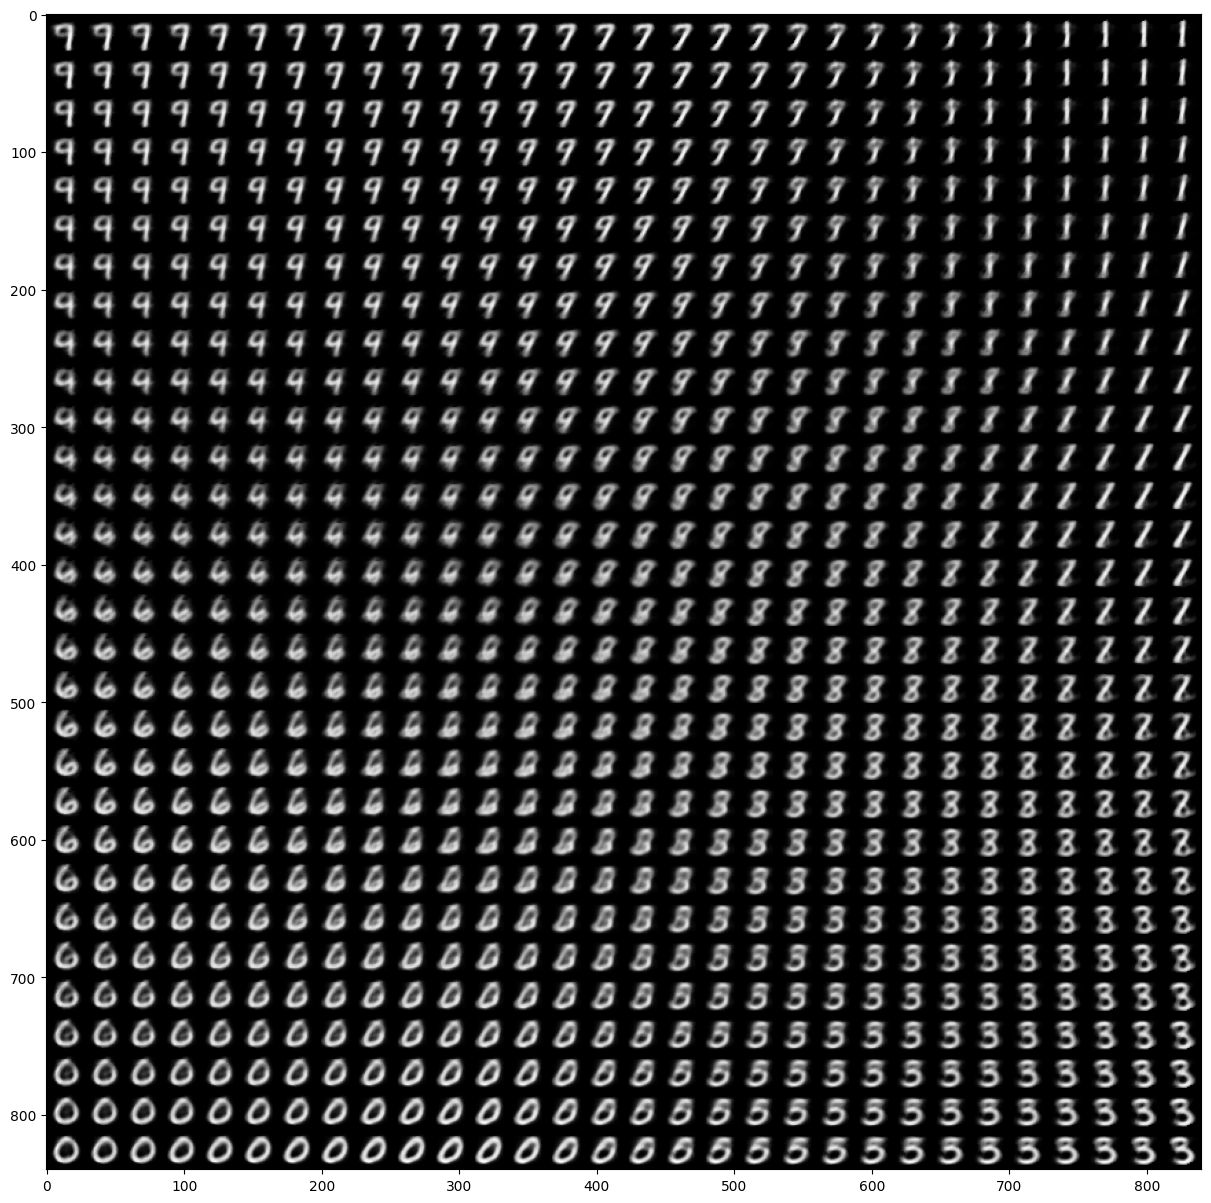

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import norm


def plot_images(decoder, n=30, figsize=15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Linearly spaced coordinates corresponding to the 2D plot
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    plt.show()

plot_images(decoder)
